# Introduction

We are working for a car insurance provider who would like to predict whether a client will submit a claim or not, and identify which factors offer contribute the most to this predictive capability.  With this information, we would be able to complete some back of the envelope math to calculate how many dollars we are likely to pay out in claims this year, and gain insight into the variables with the greatest predictive power so we can further tailor coverage packages and premiums to individual drivers.    

---- talk about the models leading up to the best.  Maybe show snapshot of results, what was done differently, what some problem may have been.... then get to the best model and talk about what we can do with it, what does it tell us... it tells us that we ultimately need more or different data to achieve our goal.  

---- what visuals to use and talk about? 


this notebook up-sampling only using resample

#### Import Dependencies

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import pandas_profiling

import itertools

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels # for confusion matrix

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import copy

#### Data Dictionary

**Data Dictionary**

- pol_eff_dt - auto insurance policy effective date
- gender - gender of driver: F, M
- agecat - driver's age category: 1 (youngest), 2, 3, 4, 5, 6
- credit_score - driver’s credit score(integer): 1-100, 1=poor, 100=excellent
- area - driver's area of residence: A, B, C, D, E, F
- traffic_index - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average
- veh_age - age of vehicle(categorical): 1 (youngest), 2, 3, 4
- veh_body - vehicle body, coded as:
    - BUS
    - CONVT = convertible  
    - COUPE   
    - HBACK = hatchback                  
    - HDTOP = hardtop
    - MCARA = motorized caravan
    - MIBUS = minibus
    - PANVN = panel van
    - RDSTR = roadster
    - SEDAN    
    - STNWG = station wagon
    - TRUCK           
    - UTE = utility
- veh_value - vehicle value, in \\$10,000s
- claim_office - office location of claim handling agent: A, B, C, D
- traffic2 - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average.  Null values have imputed mean of full dataset
- veh_value2 - vehicle value, in \\$10,000s. Null values have been replaces with the mean of the full dataset
- veh_value3 - vehicle value, in \\$10,000s. Null values have been replaces with the median of the full dataset
- veh_age2 - age of vehicle(categorical): 1 (youngest), 2, 3, 4.  Null values have been replaces with the most frequent category, which is 2
- credit2 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the mean of the full dataset
- credit3 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the median of the full dataset
- dob - driver's date of birth
- age - Driver's age at policy effective date
- claim_ind - Indicates if the policy had a claim (=1) or not
- veh_body2 - vehicle body, with a collapsed type coding, as described below.  Original coding on left, new coding on right:
    - 'BUS' = 'MIBUS',
    - 'CONVT' = 'HDTOP'
    - 'COUPE' = 'COUPE'
    - 'HBACK' = 'HBACK'
    - 'HDTOP' = 'HDTOP'
    - 'MCARA' = 'MIBUS'
    - 'MIBUS' = 'MIBUS'
    - 'PANVN' = 'PANVN'
    - 'RDSTR' = 'HDTOP'
    - 'SEDAN' = 'SEDAN'
    - STNWG' = 'STNWG'
    - 'TRUCK' = 'TRUCK'
    - 'UTE' = 'UTE'

- numclaims - number of claims(integer): 0 if no claim
- claimcst0 - claim amount: 0 if no claim.  This is the total one year claim amount (ultimate loss) for the policy. 


#### DataFrame Dictionary

# Obtaining the Data

In [2]:
data = pd.read_csv('autoinsurance_claims.csv')
data.head()

,pol_number,pol_eff_dt,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,traffic2,veh_value2,veh_value3,veh_age2,credit2,credit3,dob,age,claim_ind,veh_body2,numclaims,claimcst0
0,80750205,7/1/2015,M,4,52.0,C,93.0,4.0,STNWG,2.96,NaN,93,2.96,2.96,4,52.000000,52,2/18/1963,53,0,STNWG,0,0.0
1,90994433,8/1/2015,M,3,83.0,C,108.0,4.0,SEDAN,1.89,NaN,108,1.89,1.89,4,83.000000,83,2/18/1978,38,0,SEDAN,0,0.0
2,59239520,7/1/2015,M,5,71.0,A,NaN,3.0,SEDAN,2.75,NaN,100,2.75,2.75,3,71.000000,71,4/14/1960,56,0,SEDAN,0,0.0
3,67030771,11/1/2015,M,3,NaN,B,77.0,3.0,UTE,2.92,NaN,77,2.92,2.92,3,74.730883,81,12/23/1974,41,0,UTE,0,0.0
4,91422215,8/1/2015,M,2,88.0,D,NaN,4.0,STNWG,3.63,NaN,100,3.63,3.63,4,88.000000,88,12/25/1984,31,0,STNWG,0,0.0


In [3]:
data.shape

(60948, 23)

# Preprocessing

In [4]:
# looking for null values
data.isnull().sum()

pol_number           0
pol_eff_dt           0
gender               0
agecat               0
credit_score      3014
area                 0
traffic_index    12250
veh_age          10476
veh_body             0
veh_value         7562
claim_office     56787
traffic2             0
veh_value2           0
veh_value3           0
veh_age2             0
credit2              0
credit3              0
dob                  0
age                  0
claim_ind            0
veh_body2            0
numclaims            0
claimcst0            0
dtype: int64

__Dropping Columns__

In [5]:
# claim office is mostly empty; lets drop the feature
# we don't need the policy number either
# veh_body and veh_body2 are equal, keep veh_body2 as it is updated
# the dateTime columns create a complexity we could do without and tell us nothing since they are not the focus
  ## of the data.
# pol_eff_dt is proprietary info we don't need and dob is redundant since we have age. 
  
data.drop(['claim_office', 'pol_number', 'veh_body', 'pol_eff_dt', 'dob'], axis = 1, inplace = True)

there are duplicate columns for credit_score, traffic_index, vehicle_value, containing null values, where either the mean, median or both were used to impute missing values.  Lets keep only columns with median imputation

In [6]:
# drop credit_score and credit2 columns
# drop veh_age column.  vehicle age also has a duplicate column, where the mode was used for null values. 
  ##This is an ordinal value so keeping the mode for imputation makes sense
data.drop(['credit_score', 'credit2', 'traffic_index', 'veh_value', 'veh_value2', 'veh_age'], axis = 1, inplace = True)

In [7]:
# confirm we have no other null values
data.isnull().sum()

gender        0
agecat        0
area          0
traffic2      0
veh_value3    0
veh_age2      0
credit3       0
age           0
claim_ind     0
veh_body2     0
numclaims     0
claimcst0     0
dtype: int64

**Fix Data Types**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null object
agecat        60948 non-null int64
area          60948 non-null object
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null int64
veh_body2     60948 non-null object
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: float64(2), int64(7), object(3)
memory usage: 5.6+ MB




| Feature | Change Type to: |
|------------|---------------------|
| gender | change to category |
| agecat | change to category |
| area | change to category |
| veh_age2 | change to category |
| claim_ind | change to category |
| veh_body2 | change to category |


In [9]:
data = data.astype({'gender':'category', 'area':'category', 
             'claim_ind':'category', 'veh_body2':'category'}, inplace = True)

In [10]:
# double check the work
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null category
agecat        60948 non-null int64
area          60948 non-null category
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null category
veh_body2     60948 non-null category
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: category(4), float64(2), int64(6)
memory usage: 4.0 MB


**Edit Column Names**

Lets change a few of the column names for ease of use as we move forward and work with the data

In [11]:
data.rename(columns={'traffic2':'traffic_index', 'veh_value3':'veh_value00', 'credit3':'credit_score', 'numclaims':'num_claims', 
             'claimcst0':'claim_amount', 'veh_age2':'veh_ageIndex'}, inplace=True)

In [12]:
data.to_csv('clean_data.csv')

**Look for Multicolinearity**

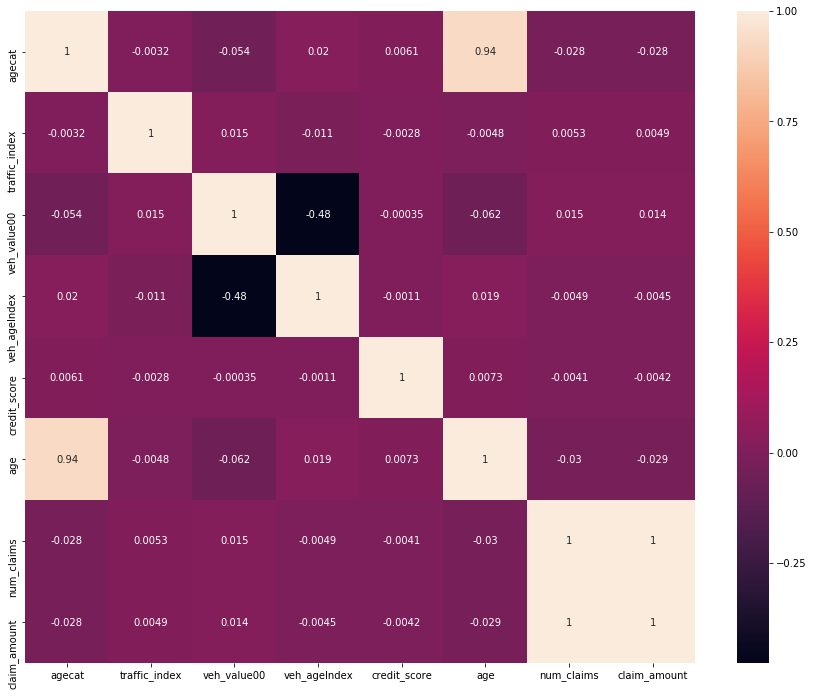

In [13]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), annot=True)

**Split data set between categorical and continuous to check distributions** which should help us decide which features to drop

I will treat ordinal features as numeric data.  Doing this requires the assumption that the numeric space between each category is equal or close to equal.   To ignore the ordering would essentially mean we could delete columns for the drivers age, the traffic index, vehicle age and credit score; that would be too much useful information to lose and an extreme downside.  The downside to treating this data as numeric is that if the spread between bins are not equal, then our results may only be approximate.  I would posit that the approximate results would be more accurate than any model that disregarded them. 

In [14]:
# create continuous sub-DataFrame

continuous = data.copy()
for i in continuous:
    if continuous[i].dtype.name == 'category':
        continuous.drop(i, axis=1, inplace = True)
continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 8 columns):
agecat           60948 non-null int64
traffic_index    60948 non-null int64
veh_value00      60948 non-null float64
veh_ageIndex     60948 non-null int64
credit_score     60948 non-null int64
age              60948 non-null int64
num_claims       60948 non-null int64
claim_amount     60948 non-null float64
dtypes: float64(2), int64(6)
memory usage: 3.7 MB


In [15]:
continuous.head()

,agecat,traffic_index,veh_value00,veh_ageIndex,credit_score,age,num_claims,claim_amount
0,4,93,2.96,4,52,53,0,0.0
1,3,108,1.89,4,83,38,0,0.0
2,5,100,2.75,3,71,56,0,0.0
3,3,77,2.92,3,81,41,0,0.0
4,2,100,3.63,4,88,31,0,0.0


In [16]:
continuous.num_claims.value_counts()

0    56787
1     3907
2      236
3       17
4        1
Name: num_claims, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B97B81B38>,
      dtype=object)

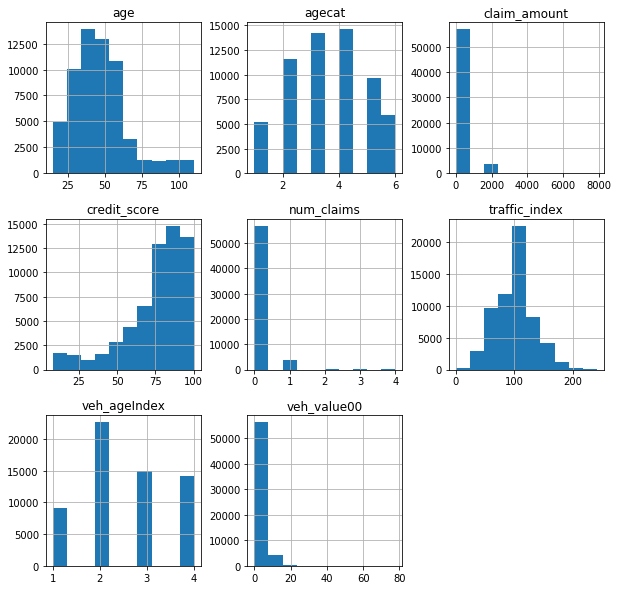

In [17]:
# inspect distributions for continuous data
continuous.hist(figsize=(10,10))

we have colinearity between:
- age & agecat
- num_claims & claim_amount  
lets drop age since agecat looks like a better distribution.  
claim amount and num_claims end up distorting the models so lets drop them both. 

In [18]:
def print_value_counts(df):
    
    for col in df:
        print(col,':')
        print(df[col].value_counts(),'\n')
print_value_counts(continuous)

agecat :
4    14585
3    14177
2    11539
5     9634
6     5853
1     5160
Name: agecat, dtype: int64 

traffic_index :
100    12760
76       562
72       558
84       544
77       544
75       531
86       527
79       516
80       508
82       507
90       503
91       503
81       502
66       499
73       497
74       497
78       496
89       491
87       488
69       486
93       485
65       483
98       481
83       481
70       477
85       474
71       470
63       468
96       462
102      461
       ...  
5          5
4          5
205        5
0          4
208        4
217        4
9          4
204        4
13         4
206        4
212        3
8          3
203        3
224        3
2          3
220        2
216        2
1          2
215        2
6          2
3          2
241        1
230        1
235        1
11         1
232        1
218        1
221        1
222        1
223        1
Name: traffic_index, Length: 228, dtype: int64 

veh_value00 :
3.38     7942
3.06      

In [19]:
# log transform
cont_log = np.log(continuous)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [20]:
cont_log.num_claims.value_counts()

-inf         56787
 0.000000     3907
 0.693147      236
 1.098612       17
 1.386294        1
Name: num_claims, dtype: int64

In [21]:
cont_log.replace(-np.inf, np.nan, inplace=True)
cont_log.replace(np.nan, 0, inplace=True)

In [22]:
cont_log.num_claims.value_counts()

0.000000    60694
0.693147      236
1.098612       17
1.386294        1
Name: num_claims, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B97D2B9B0>,
      dtype=object)

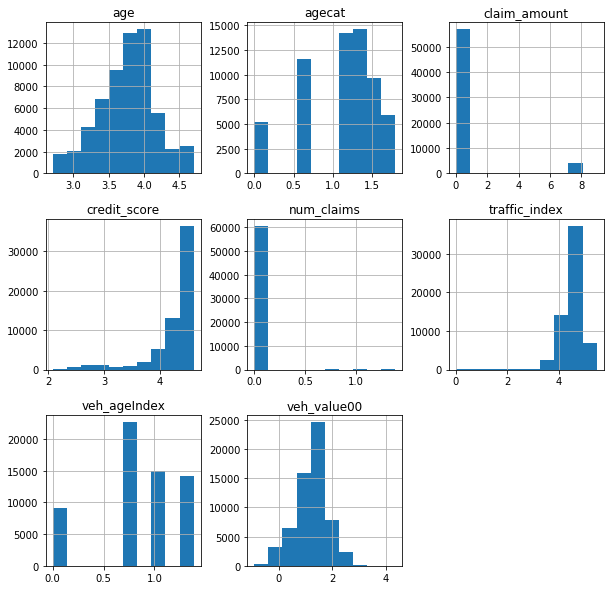

In [23]:
# inspect distributions for continuous data
cont_log.hist(figsize=(10,10))

veh_value, claim_amount and num_claims are so heavily skewed that it doesnt make sense to keep the columns.  In addition, the multicolinearity presents a problem.

In [24]:
cont_log.head()

,agecat,traffic_index,veh_value00,veh_ageIndex,credit_score,age,num_claims,claim_amount
0,1.386294,4.532599,1.085189,1.386294,3.951244,3.970292,0.0,0.0
1,1.098612,4.682131,0.636577,1.386294,4.418841,3.637586,0.0,0.0
2,1.609438,4.605170,1.011601,1.098612,4.262680,4.025352,0.0,0.0
3,1.098612,4.343805,1.071584,1.098612,4.394449,3.713572,0.0,0.0
4,0.693147,4.605170,1.289233,1.386294,4.477337,3.433987,0.0,0.0


**remove features causing multicolinearity**

In [25]:
cont_log.drop(['num_claims', 'claim_amount', 'veh_value00', 'agecat'],axis=1, inplace=True)

In [26]:
# create categorical sub-DataFrame

categorical = data.copy()
for i in categorical:
    if categorical[i].dtype.name != 'category':
        categorical.drop(i, axis = 1, inplace=True)
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 238.9 KB


**Get Dummies for categorical data**

In [27]:
categorical.head()

,gender,area,claim_ind,veh_body2
0,M,C,0,STNWG
1,M,C,0,SEDAN
2,M,A,0,SEDAN
3,M,B,0,UTE
4,M,D,0,STNWG


In [28]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 238.9 KB


In [29]:
categorical.veh_body2.value_counts()

SEDAN    19981
HBACK    16966
STNWG    14646
UTE       4108
TRUCK     1576
HDTOP     1506
MIBUS      794
COUPE      704
PANVN      667
Name: veh_body2, dtype: int64

In [30]:
# one-hot encode categorical data
dummies = pd.get_dummies(categorical.drop('claim_ind', axis=1))
dummies.head()

,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [31]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 17 columns):
gender_F           60948 non-null uint8
gender_M           60948 non-null uint8
area_A             60948 non-null uint8
area_B             60948 non-null uint8
area_C             60948 non-null uint8
area_D             60948 non-null uint8
area_E             60948 non-null uint8
area_F             60948 non-null uint8
veh_body2_COUPE    60948 non-null uint8
veh_body2_HBACK    60948 non-null uint8
veh_body2_HDTOP    60948 non-null uint8
veh_body2_MIBUS    60948 non-null uint8
veh_body2_PANVN    60948 non-null uint8
veh_body2_SEDAN    60948 non-null uint8
veh_body2_STNWG    60948 non-null uint8
veh_body2_TRUCK    60948 non-null uint8
veh_body2_UTE      60948 non-null uint8
dtypes: uint8(17)
memory usage: 1011.9 KB


**concat the continuous and categorical DataFrames**

this df:  
- log transformed 
- multicolinearity removed

In [32]:
#beginning processed dataframe
df = pd.concat([cont_log, dummies, categorical.claim_ind], axis = 1, sort=False)
df.head()

,traffic_index,veh_ageIndex,credit_score,age,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,4.532599,1.386294,3.951244,3.970292,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,4.682131,1.386294,4.418841,3.637586,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,4.605170,1.098612,4.262680,4.025352,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4.343805,1.098612,4.394449,3.713572,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4.605170,1.386294,4.477337,3.433987,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


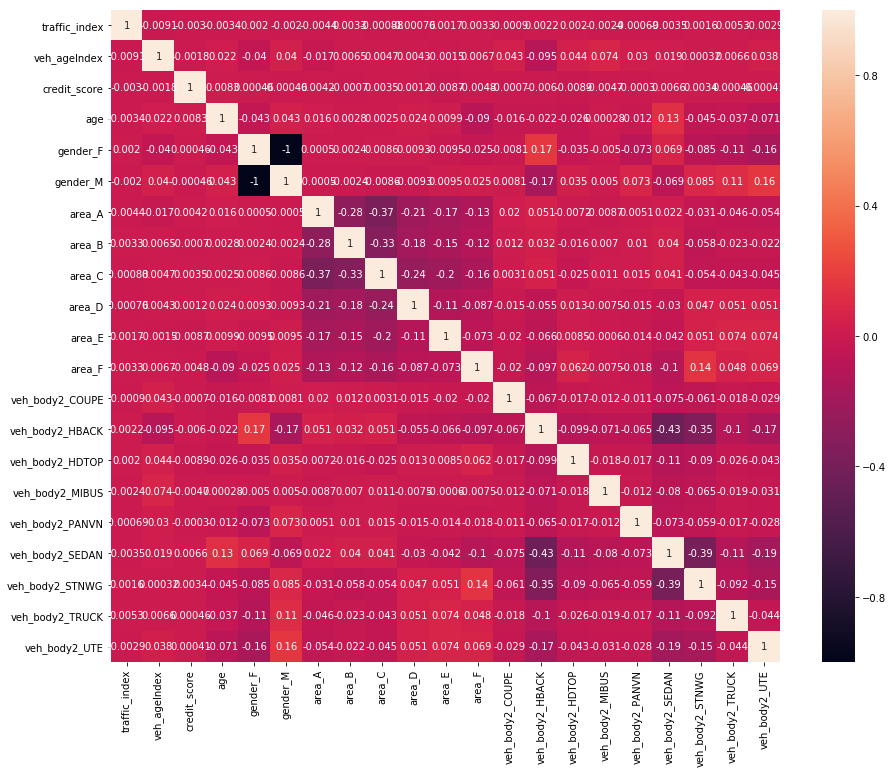

In [33]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True)

In [34]:
df.claim_ind.value_counts()

0    56787
1     4161
Name: claim_ind, dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 22 columns):
traffic_index      60948 non-null float64
veh_ageIndex       60948 non-null float64
credit_score       60948 non-null float64
age                60948 non-null float64
gender_F           60948 non-null uint8
gender_M           60948 non-null uint8
area_A             60948 non-null uint8
area_B             60948 non-null uint8
area_C             60948 non-null uint8
area_D             60948 non-null uint8
area_E             60948 non-null uint8
area_F             60948 non-null uint8
veh_body2_COUPE    60948 non-null uint8
veh_body2_HBACK    60948 non-null uint8
veh_body2_HDTOP    60948 non-null uint8
veh_body2_MIBUS    60948 non-null uint8
veh_body2_PANVN    60948 non-null uint8
veh_body2_SEDAN    60948 non-null uint8
veh_body2_STNWG    60948 non-null uint8
veh_body2_TRUCK    60948 non-null uint8
veh_body2_UTE      60948 non-null uint8
claim_ind          60948 non-null category


In [36]:
pandas_profiling.ProfileReport(df)

Number of variables,22
Number of observations,60948
Total Missing (%),0.0%
Total size in memory,2.9 MiB
Average record size in memory,50.0 B
Numeric,4
Categorical,1
Boolean,17
Date,0
Text (Unique),0
Rejected,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 22 columns):
traffic_index      60948 non-null float64
veh_ageIndex       60948 non-null float64
credit_score       60948 non-null float64
age                60948 non-null float64
gender_F           60948 non-null uint8
gender_M           60948 non-null uint8
area_A             60948 non-null uint8
area_B             60948 non-null uint8
area_C             60948 non-null uint8
area_D             60948 non-null uint8
area_E             60948 non-null uint8
area_F             60948 non-null uint8
veh_body2_COUPE    60948 non-null uint8
veh_body2_HBACK    60948 non-null uint8
veh_body2_HDTOP    60948 non-null uint8
veh_body2_MIBUS    60948 non-null uint8
veh_body2_PANVN    60948 non-null uint8
veh_body2_SEDAN    60948 non-null uint8
veh_body2_STNWG    60948 non-null uint8
veh_body2_TRUCK    60948 non-null uint8
veh_body2_UTE      60948 non-null uint8
claim_ind          60948 non-null category


# Logistic Regression Models

## LR Model 1

Using SMOTE

In [38]:
LR_X = copy.deepcopy(df[df.columns[0:-1]])
LR_y = copy.deepcopy(df.claim_ind)

# split data set between test and train
X_train, X_test, y_train, y_test = train_test_split(LR_X, LR_y, test_size = 0.25, random_state = 42)

# complete SMOTE on train sample only
X_train_SMOTE, y_train_SMOTE = SMOTE().fit_sample(X_train, y_train)
           
# create a logistic regression classifier object and fit a model
logReg_classifier = LogisticRegression()
logReg_model = logReg_classifier.fit(X_train_SMOTE, y_train_SMOTE)
print(logReg_model)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [39]:
# generating predictions
y_hat_train = logReg_model.predict(X_train_SMOTE)
y_hat_test = logReg_model.predict(X_test)

print(f" Train set Accuracy: {round(accuracy_score(y_train_SMOTE, y_hat_train),2)}")
print(f" Test set Accuracy: {round(accuracy_score(y_test, y_hat_test),2)}")
"n*"
"n*"
print(classification_report(y_test,y_hat_test))

 Train set Accuracy: 0.53
 Test set Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.94      0.51      0.66     14194
           1       0.08      0.55      0.13      1043

   micro avg       0.51      0.51      0.51     15237
   macro avg       0.51      0.53      0.40     15237
weighted avg       0.88      0.51      0.62     15237



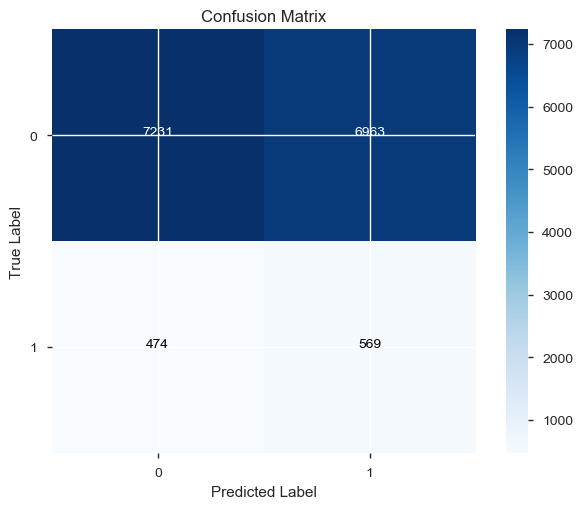

In [40]:
# Confusion Matrix

def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

show_cf(y_test, y_hat_test)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.5407581437932196


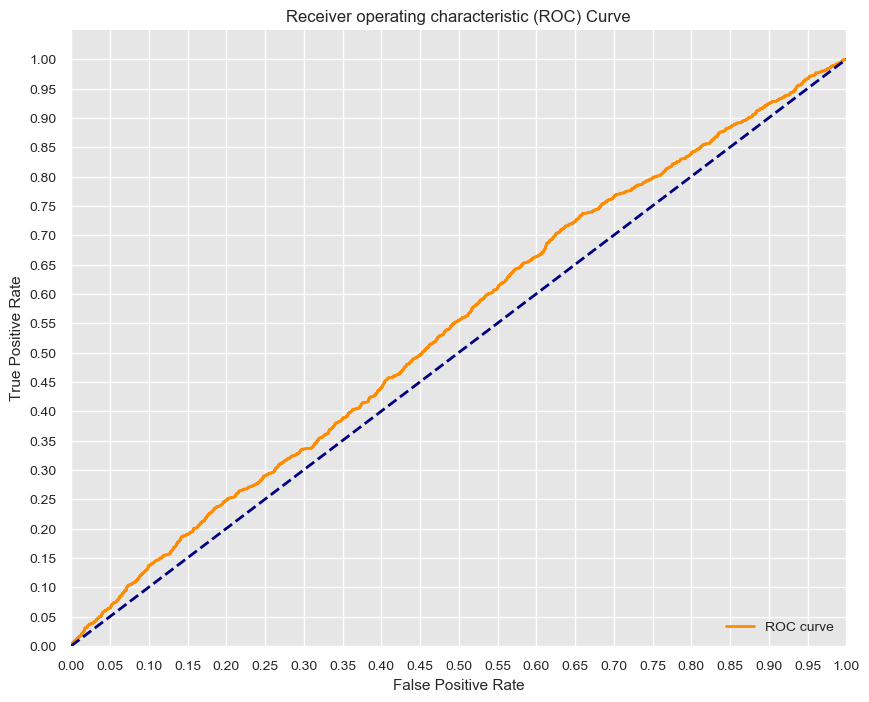

In [41]:
# calculate and plot ROC curve

y_score = logReg_model.fit(X_train_SMOTE, y_train_SMOTE).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## LR Model 2

using `resample` instead of SMOTE

In [42]:
%whos

Variable                 Type                  Data/Info
--------------------------------------------------------
ADASYN                   ABCMeta               <class 'imblearn.over_sampling._adasyn.ADASYN'>
BaggingClassifier        ABCMeta               <class 'sklearn.ensemble.<...>gging.BaggingClassifier'>
GridSearchCV             ABCMeta               <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LR_X                     DataFrame                    traffic_index  veh<...>[60948 rows x 21 columns]
LR_y                     Series                0        0\n1        0\n2<...>gories (2, int64): [0, 1]
LogisticRegression       type                  <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
OneHotEncoder            type                  <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
RandomForestClassifier   ABCMeta               <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SMOTE                    ABCMeta               <class 'imblearn.over_s

In [43]:
LR_X_2 = copy.deepcopy(df[df.columns[0:-1]])
LR_y_2 = copy.deepcopy(df.claim_ind)

# split data set between test and train
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(LR_X_2, LR_y_2, test_size = 0.25, random_state = 42)

In [44]:
# upsampling using .resample()

# concatenate our training data back together
training_data = pd.concat([X_train_2, y_train_2], axis=1)

# separate minority and majority classes
no_claim = training_data[training_data.claim_ind==0] # majority
file_claim = training_data[training_data.claim_ind==1] # minority

# upsample minority
file_claim_upsampled = resample(file_claim,
                          replace=True, # sample with replacement
                          n_samples=len(no_claim), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([file_claim_upsampled, no_claim])

# split features and target again
X_train_up = upsampled.drop(['claim_ind'], axis = 1) 
y_train_up = upsampled.claim_ind

In [45]:
# create a logistic regression classifier object and fit a model
logReg_classifier = LogisticRegression()
logReg_model_2 = logReg_classifier.fit(X_train_up, y_train_up)
print(logReg_model)
print() 
print()
# generating predictions
y_hat_train_2 = logReg_model_2.predict(X_train_up)
y_hat_test_2 = logReg_model_2.predict(X_test_2)

print(f" Train set Accuracy: {round(accuracy_score(y_train_up, y_hat_train_2),2)}")
print(f" Test set Accuracy: {round(accuracy_score(y_test_2, y_hat_test_2),2)}")
print()
print()
print(classification_report(y_test_2, y_hat_test_2))

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


 Train set Accuracy: 0.52
 Test set Accuracy: 0.52


              precision    recall  f1-score   support

           0       0.94      0.52      0.67     14194
           1       0.08      0.53      0.13      1043

   micro avg       0.52      0.52      0.52     15237
   macro avg       0.51      0.53      0.40     15237
weighted avg       0.88      0.52      0.63     15237



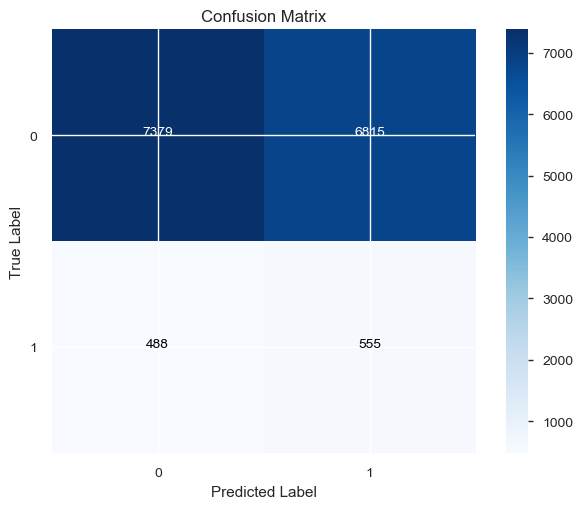

In [46]:
show_cf(y_test_2, y_hat_test_2)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.545508574443903


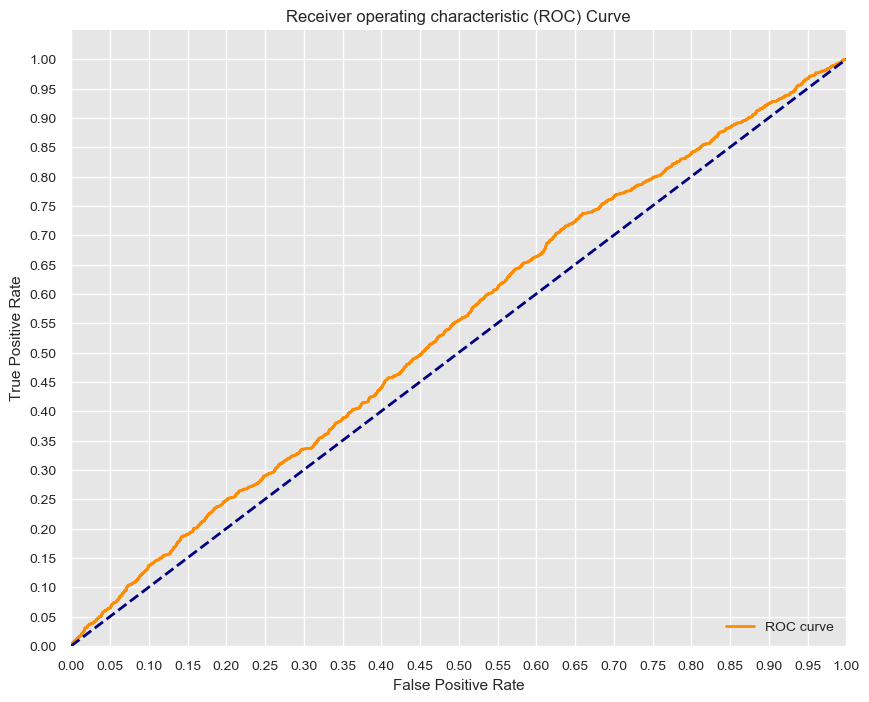

In [47]:
# calculate and plot ROC curve

y_score_2 = logReg_model_2.fit(X_train_up, y_train_up).decision_function(X_test_2)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_2, y_score_2)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr_2, tpr_2)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest Models

## RF Model 1

using SMOTE

In [48]:
RF_X = copy.deepcopy(df[df.columns[0:-1]])
RF_y = copy.deepcopy(df.claim_ind)

# split data set between test and train
RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split(RF_X, RF_y, test_size = 0.25, random_state = 42)

# complete SMOTE on train sample only
RF_X_train_SMOTE, RF_y_train_SMOTE = SMOTE().fit_sample(RF_X_train, RF_y_train)

In [49]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(RF_X_train_SMOTE, RF_y_train_SMOTE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
RF_pred = forest.predict(RF_X_test)

print(f"Accuracy Score Random Forest Model #1 Test Set: {round(accuracy_score(RF_y_test, RF_pred),2)}")
print()
print()
print("Classification Report")
print(classification_report(RF_y_test, RF_pred))

Accuracy Score Random Forest Model #1 Test Set: 0.56


Classification Report
              precision    recall  f1-score   support

           0       0.94      0.56      0.70     14194
           1       0.07      0.47      0.13      1043

   micro avg       0.56      0.56      0.56     15237
   macro avg       0.50      0.52      0.42     15237
weighted avg       0.88      0.56      0.67     15237



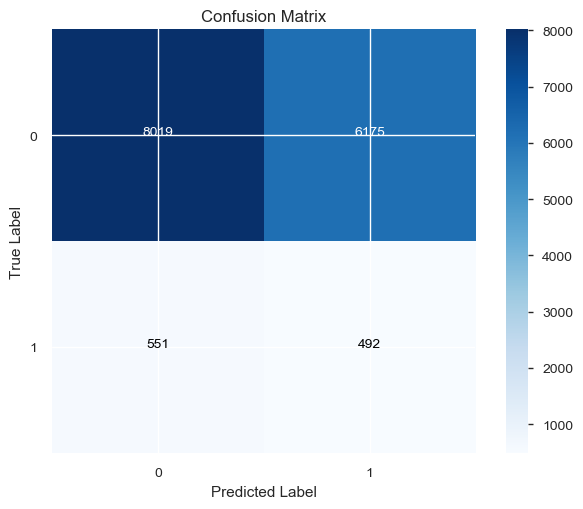

In [51]:
show_cf(RF_y_test, RF_pred)

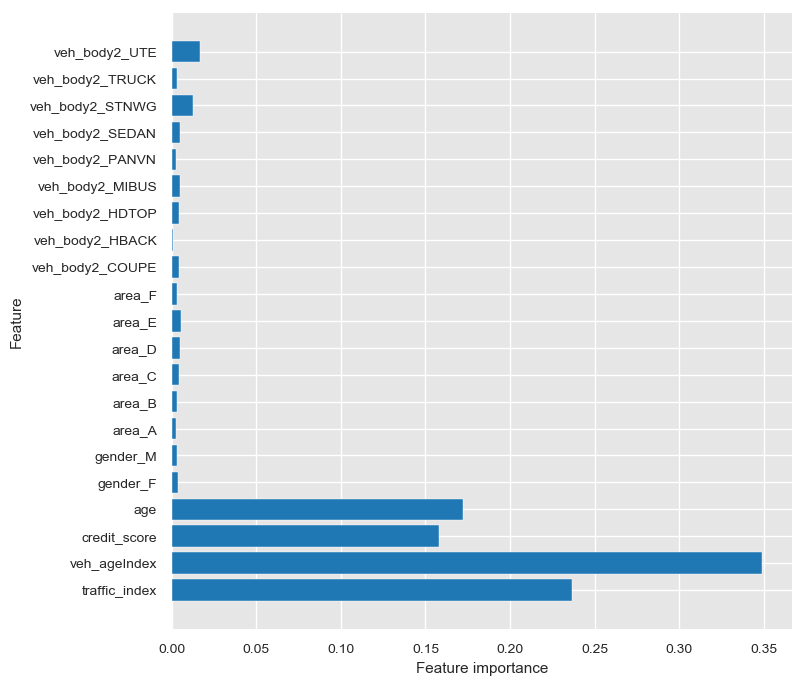

In [52]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances(forest, pd.DataFrame(RF_X_train))

In [53]:
for name, importance in zip(pd.DataFrame(RF_X_train).columns, forest.feature_importances_):
    print(name, "=", f"{round(importance*100)}'%'")

traffic_index = 24.0'%'
veh_ageIndex = 35.0'%'
credit_score = 16.0'%'
age = 17.0'%'
gender_F = 0.0'%'
gender_M = 0.0'%'
area_A = 0.0'%'
area_B = 0.0'%'
area_C = 0.0'%'
area_D = 0.0'%'
area_E = 1.0'%'
area_F = 0.0'%'
veh_body2_COUPE = 0.0'%'
veh_body2_HBACK = 0.0'%'
veh_body2_HDTOP = 0.0'%'
veh_body2_MIBUS = 0.0'%'
veh_body2_PANVN = 0.0'%'
veh_body2_SEDAN = 0.0'%'
veh_body2_STNWG = 1.0'%'
veh_body2_TRUCK = 0.0'%'
veh_body2_UTE = 2.0'%'


In [54]:
my_dict = {}

for name, importance in zip(pd.DataFrame(RF_X_train).columns, forest.feature_importances_):
    my_dict[name] = importance

In [55]:
print(sorted(my_dict))

['age', 'area_A', 'area_B', 'area_C', 'area_D', 'area_E', 'area_F', 'credit_score', 'gender_F', 'gender_M', 'traffic_index', 'veh_ageIndex', 'veh_body2_COUPE', 'veh_body2_HBACK', 'veh_body2_HDTOP', 'veh_body2_MIBUS', 'veh_body2_PANVN', 'veh_body2_SEDAN', 'veh_body2_STNWG', 'veh_body2_TRUCK', 'veh_body2_UTE']


In [56]:
sorted_dict = sorted((value, key) for (key,value) in my_dict.items())
sorted_dict

[(0.0010253681566322697, 'veh_body2_HBACK'),
 (0.00258815874529003, 'veh_body2_PANVN'),
 (0.002589273784363153, 'area_A'),
 (0.0028783574280978256, 'veh_body2_TRUCK'),
 (0.003067705748083807, 'area_F'),
 (0.003079815743721001, 'gender_M'),
 (0.0031363166705203082, 'area_B'),
 (0.003426836290871234, 'gender_F'),
 (0.0041219875916756795, 'veh_body2_COUPE'),
 (0.004234569925351185, 'veh_body2_HDTOP'),
 (0.004349523011114205, 'area_C'),
 (0.004726039991092792, 'veh_body2_SEDAN'),
 (0.00488384800241231, 'area_D'),
 (0.0049912772590926515, 'veh_body2_MIBUS'),
 (0.005747258718729179, 'area_E'),
 (0.01244033060158146, 'veh_body2_STNWG'),
 (0.016828140823218193, 'veh_body2_UTE'),
 (0.15806432466728107, 'credit_score'),
 (0.1722071323380472, 'age'),
 (0.23647221279866315, 'traffic_index'),
 (0.34914152170416135, 'veh_ageIndex')]

## RF Model 2

- using SMOTE
- After Feature Elimination

In [57]:
RF_X_2 = copy.deepcopy(df[['veh_ageIndex', 'age', 'credit_score', 'traffic_index']])
RF_y_2 = copy.deepcopy(df.claim_ind)

# split data set between test and train
RF_X_train_2, RF_X_test_2, RF_y_train_2, RF_y_test_2 = train_test_split(RF_X_2, RF_y_2, test_size = 0.25, random_state = 42)

# complete SMOTE on train sample only
RF_X_train_SMOTE_2, RF_y_train_SMOTE_2 = SMOTE().fit_sample(RF_X_train_2, RF_y_train_2)

In [58]:
forest_2 = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest_2.fit(RF_X_train_SMOTE_2, RF_y_train_SMOTE_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
RF_pred_2 = forest_2.predict(RF_X_test_2)

print(f"Accuracy Score Random Forest Model #2 Test Set: {round(accuracy_score(RF_y_test_2, RF_pred_2),2)}")
print()
print()
print("Classification Report")
print(classification_report(RF_y_test_2, RF_pred_2))

Accuracy Score Random Forest Model #2 Test Set: 0.45


Classification Report
              precision    recall  f1-score   support

           0       0.94      0.44      0.60     14194
           1       0.07      0.61      0.13      1043

   micro avg       0.45      0.45      0.45     15237
   macro avg       0.51      0.52      0.37     15237
weighted avg       0.88      0.45      0.57     15237



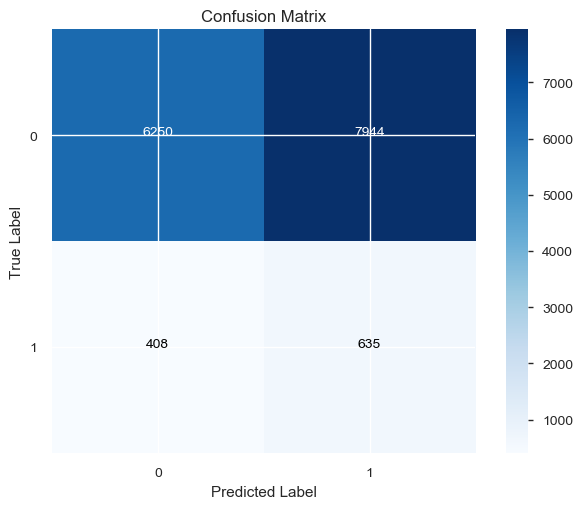

In [60]:
show_cf(RF_y_test_2, RF_pred_2)

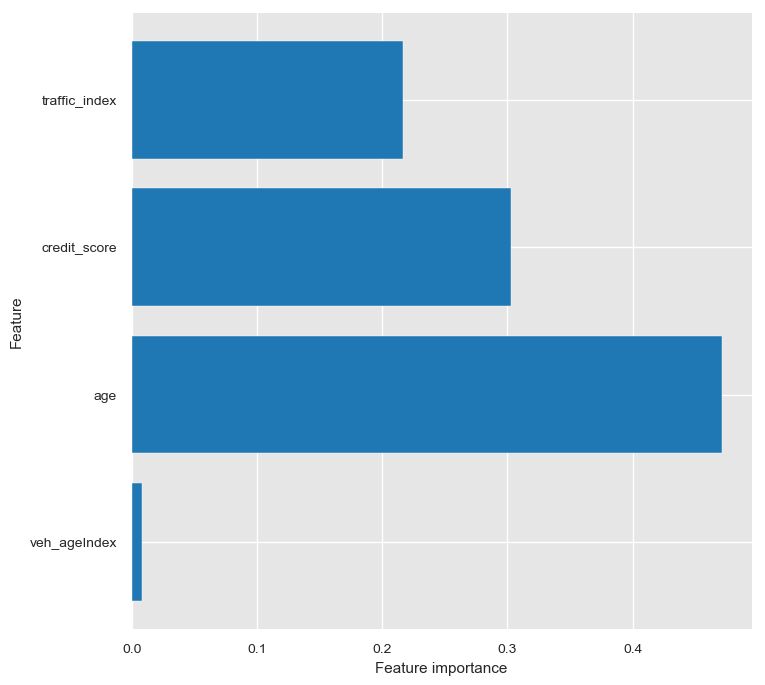

In [61]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(forest_2, pd.DataFrame(RF_X_train_2))

# XGBoost Models

## XGBoost Model 1

In [62]:
# define X and y
boost_X = copy.deepcopy(df[df.columns[0:-1]])
boost_y = copy.deepcopy(df.claim_ind)

# train-test split
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(boost_X, boost_y,  test_size = 0.25, 
                                                                                        random_state=42)

# upsample with SMOTE
X_train_boost_SMOTE, y_train_boost_SMOTE = SMOTE().fit_sample(X_train_boost, y_train_boost)

# coerce upsampled data into a df
X_train_boost_SMOTE_df =  pd.DataFrame(X_train_boost_SMOTE, columns = X_train_boost.columns)

# create an XGBoost classifier object
boost_clf = xgb.XGBClassifier()

# use XGBoost to fit our x and y training data
boost_clf.fit(X_train_boost_SMOTE_df, y_train_boost_SMOTE)

# generate predictions using training features
boost_training_preds = boost_clf.predict(X_train_boost_SMOTE_df)
# generate predictions using test features
boost_test_preds = boost_clf.predict(X_test_boost)

In [63]:
boost_training_accuracy = accuracy_score(y_train_boost_SMOTE, boost_training_preds)
boost_test_accuracy = accuracy_score(y_test_boost, boost_test_preds)

print("Training Accuracy: {:.4}%".format(boost_training_accuracy * 100))
print("Test accuracy: {:.4}%".format(boost_test_accuracy * 100))
print()
print()

print(classification_report(y_test_boost, boost_test_preds))

Training Accuracy: 68.92%
Test accuracy: 85.71%


              precision    recall  f1-score   support

           0       0.93      0.91      0.92     14194
           1       0.07      0.09      0.08      1043

   micro avg       0.86      0.86      0.86     15237
   macro avg       0.50      0.50      0.50     15237
weighted avg       0.87      0.86      0.86     15237



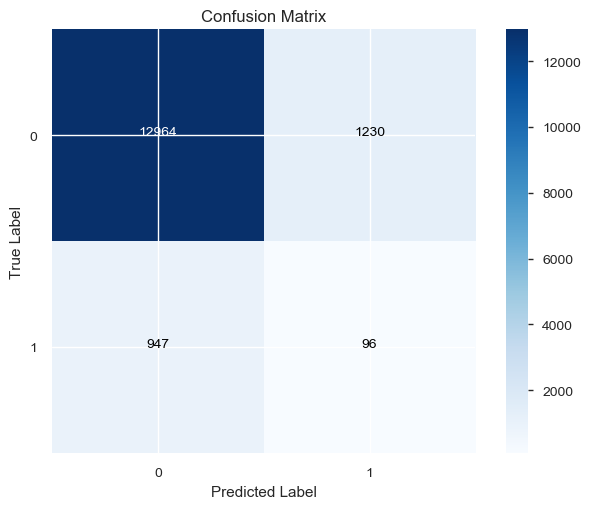

In [64]:
show_cf(y_test_boost, boost_test_preds)

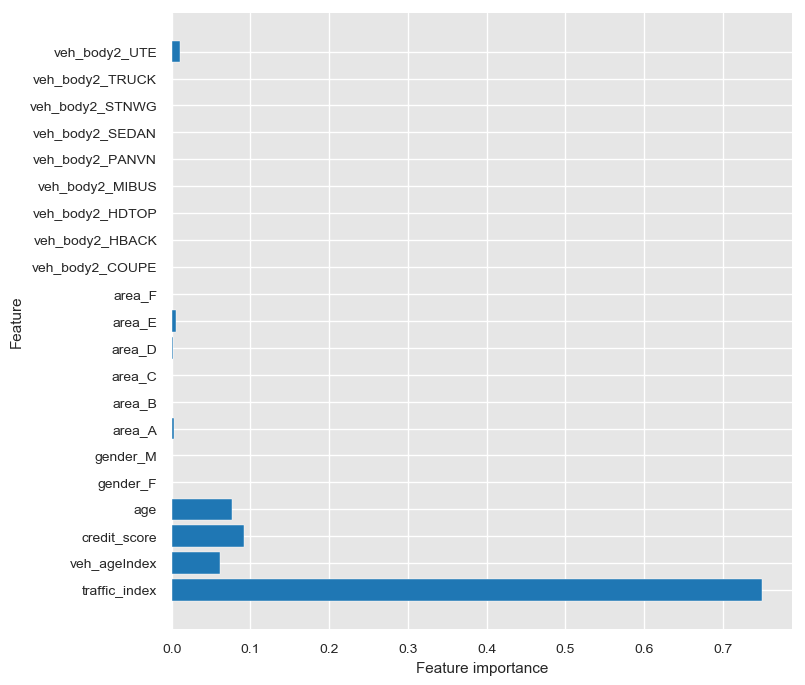

In [65]:
plot_feature_importances(boost_clf, X_train_boost_SMOTE_df) # training data param here is just to get column headers for graph

In [66]:
%whos

Variable                   Type                      Data/Info
--------------------------------------------------------------
ADASYN                     ABCMeta                   <class 'imblearn.over_sampling._adasyn.ADASYN'>
BaggingClassifier          ABCMeta                   <class 'sklearn.ensemble.<...>gging.BaggingClassifier'>
GridSearchCV               ABCMeta                   <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LR_X                       DataFrame                        traffic_index  veh<...>[60948 rows x 21 columns]
LR_X_2                     DataFrame                        traffic_index  veh<...>[60948 rows x 21 columns]
LR_y                       Series                    0        0\n1        0\n2<...>gories (2, int64): [0, 1]
LR_y_2                     Series                    0        0\n1        0\n2<...>gories (2, int64): [0, 1]
LogisticRegression         type                      <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
OneHotEnco

In [67]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [7],
    'min_child_weight': [9],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250, 500],
    
}

In [68]:
import time
start = time.time()

grid_clf = GridSearchCV(boost_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_boost_SMOTE_df, y_train_boost_SMOTE)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_boost_SMOTE_df)
test_preds = grid_clf.predict(X_test_boost)
training_accuracy = accuracy_score(y_train_boost_SMOTE, training_preds)
test_accuracy = accuracy_score(y_test_boost, test_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(test_accuracy * 100))

end = time.time()
print(end - start)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 7
min_child_weight: 9
n_estimators: 500
subsample: 0.7

Training Accuracy: 96.26%
Validation accuracy: 93.15%
291.9550242424011


**XGBoost Classification Report**

In [69]:
print(classification_report(y_test_boost, test_preds))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     14194
           1       0.00      0.00      0.00      1043

   micro avg       0.93      0.93      0.93     15237
   macro avg       0.47      0.50      0.48     15237
weighted avg       0.87      0.93      0.90     15237



C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
